In [1505]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1506]:
# %run drive/MyDrive/ZAD2/eda.ipynb

In [1507]:
# !pip install sklearn-evaluation

In [1508]:
import pandas as pd
import numpy as np
from pyparsing import col
from sqlalchemy import column
import collections 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import datasets
from sklearn_evaluation import plot
import plotly.express as px
import time

train_data = pd.read_csv('drive/MyDrive/ZAD2/train_dummy.csv', low_memory=False)           
test_data = pd.read_csv('drive/MyDrive/ZAD2/test_dummy.csv') 

Nacitanie dat z disku a importovanie potrebnych kniznic

In [1509]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

train_data_columns = train_data.columns
test_data_columns = test_data.columns

# print(train_data.head())

train_data_scaled =  scale.fit_transform(train_data)
test_data_scaled = scale.fit_transform(test_data)

train_data = pd.DataFrame(train_data_scaled, columns = train_data_columns)
test_data = pd.DataFrame(test_data_scaled, columns = test_data_columns)

# print(train_data.head())


MinMaxScaler na skalovanie dat pre podobne hodnoty vo vsetkych stlpcoch

In [1510]:
Xcol = train_data.drop(columns=['SalePrice'])

X = train_data.drop(columns=['SalePrice'])
X_test = test_data.drop(columns=['SalePrice'])
Y_test = test_data['SalePrice']
Y = train_data['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 45)

Rozdelenie dat na validacne a trenovacie v pomere 7:3

In [1511]:
https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn

subtrain_data_columns = ['TotalBsmtSF','GrLivArea','1stFlrSF','ExterQual_TA','GarageCars','ExterQual_Gd','BsmtQual_TA','GarageArea',
'OpenPorchSF','FullBath','BsmtFinSF1','KitchenQual_Ex','LotArea','YearBuilt','Fireplaces','ExterQual_Ex','Neighborhood_NridgHt',
'KitchenQual_TA','MasVnrType_Stone','TotRmsAbvGrd','GarageYrBlt',  'MasVnrArea','BsmtFinType1_GLQ','2ndFlrSF','SaleCondition_Partial',
'YearRemodAdd','Foundation_CBlock','GarageFinish_Unf','GarageType_Detchd','MasVnrType_None']


data_corr = train_data[subtrain_data_columns]

fig, ax = plt.subplots(figsize=(10,10))     
sn.heatmap(data_corr.corr(), linewidths=1, ax=ax)
plt.show()

Koleracna matica so vsetkymi stlpcami z databazy

In [1512]:
# https://www.w3schools.com/python/python_ml_decision_tree.asp
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

features = list(train_data.columns)

tree_para = {
    'criterion': ["squared_error", "mse", "friedman_mse", "absolute_error"],
    'splitter' : ["best", "random"],
    'max_depth':[7, 8, 9],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_leaf_nodes': [20, 30, 40],
    }

dtree = DecisionTreeRegressor()

clf = GridSearchCV(
    estimator = dtree, 
    param_grid = tree_para, 
    cv=4,
    verbose=4
    )

clf.fit(x_train, y_train)

best_params = clf.best_params_
best_score = clf.best_score_
print('Best params: ',best_params)
print('Best scores: ',best_score)

best_tree = clf.best_estimator_

print('R2:', r2_score(y_test, best_tree.predict(x_test))) #R2
print('MSE:', mean_squared_error(y_test, best_tree.predict(x_test)))

tree.plot_tree(best_tree, filled=True)
plt.savefig('out.pdf')

visualizer = ResidualsPlot(best_tree)
visualizer.fit(x_train, y_train)  
visualizer.score(x_test, y_test)  
visualizer.show()


Model rozhodovacieho stromu s viacerymi parametrami optimalizovany cez grid search s cross validation, nasledne vypis najlepsieho skore, najlepsich parametrov a mse a r2

In [1513]:
# https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a
# https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

svr_para = {
    'kernel': ['rbf'],
    'C': [1,10, 50, 100], 
    'gamma': [0.1, 0.001]
  }

svr = SVR()

clf = GridSearchCV(
        estimator = svr, 
        param_grid = svr_para, 
        cv = 7,
        verbose = 4,
        return_train_score = True
    )

clf.fit(x_train, y_train)

best_params = clf.best_params_
best_score = clf.best_score_
print('Best params: ',best_params)
print('Best scores: ',best_score)

best_svr = clf.best_estimator_

print('R2:', r2_score(y_test, best_svr.predict(x_test))) #R2
print('MSE:', mean_squared_error(y_test, best_svr.predict(x_test)))

visualizer = ResidualsPlot(best_svr)
visualizer.fit(x_train, y_train) 
visualizer.score(x_test, y_test) 
visualizer.show()

plot.grid_search(clf.cv_results_, change='C')


Model SVC s viacerymi parametrami optimalizovany cez grid search s cross validation, nasledne vypis najlepsieho skore, najlepsich parametrov a mse a r2

In [1514]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Create the parameter grid based on the results of random search 
rf_para = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [10, 12, 14],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [80, 100, 120]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
clf = GridSearchCV(
    estimator = rf, 
    param_grid = rf_para, 
    cv = 5,   
    verbose = 3)

# Fit the grid search to the data
clf.fit(x_train, y_train)

best_params = clf.best_params_
best_score = clf.best_score_
print('Best params: ',best_params)
print('Best scores: ',best_score)

best_rf = clf.best_estimator_

print('Test R2 Score:', r2_score(y_test, best_rf.predict(x_test))) #R2
print('Test MSE Score:', mean_squared_error(y_test, best_rf.predict(x_test)))

visualizer = ResidualsPlot(best_rf)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

feat_importances = pd.Series(best_rf.feature_importances_, index=Xcol.columns)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

plt.rcParams.update({'font.size': 10})
plt.ylabel("Priznaky")
plt.xlabel("Pouzitie")
plt.barh(Xcol.columns, best_rf.feature_importances_)
plt.title(label='Sila vstupnych priznakov')


Model nadhodneho lesu s viacerymi parametrami optimalizovany cez grid search s cross validation, nasledne vypis najlepsieho skore, najlepsich parametrov a mse a r2

In [1515]:
x = train_data['YearBuilt']
y = train_data['YrSold']
z = train_data['OverallCond']
c = train_data['SalePrice']

fig = px.scatter_3d(
    x=x, y=y, z=z, color=c,
    labels={'x': x.name, 'y': y.name, 'z': z.name, 'c': c.name}
)
fig.show()


Vykreslenie 3d grafu a analyza stlpcov rok postavenia domu, rok predania domu a kondicie domu

Best scores:  0.8632473110065554
Time: 0.07150578498840332


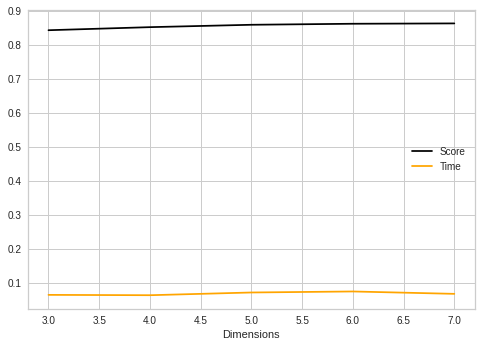

In [1517]:
# https://www.youtube.com/watch?v=h6MCf89GqCM&ab_channel=GregHogg
# https://plotly.com/python/3d-scatter-plots/

subtrain_data_columns = ['TotalBsmtSF','GrLivArea','1stFlrSF','ExterQual_TA','GarageCars','ExterQual_Gd','BsmtQual_TA','GarageArea',
'OpenPorchSF','FullBath','BsmtFinSF1','KitchenQual_Ex','LotArea','YearBuilt','Fireplaces','ExterQual_Ex','Neighborhood_NridgHt',
'KitchenQual_TA','MasVnrType_Stone','TotRmsAbvGrd','GarageYrBlt',  'MasVnrArea','BsmtFinType1_GLQ','2ndFlrSF','SaleCondition_Partial',
'YearRemodAdd','Foundation_CBlock','GarageFinish_Unf','GarageType_Detchd','MasVnrType_None']

sub_train = X[subtrain_data_columns].values
sub_test = X_test[subtrain_data_columns].values

pca = decomposition.PCA()
pca.n_components = 7
pca_data = pca.fit_transform(sub_train)
pca_test = pca.transform(sub_test)


fig = px.scatter_3d(pca_data, x = 0, y = 1, z = 2, color = Y, labels={'0': '1.Dimenzia', '1': '2.Dimenzia', '2': '3.Dimenzia'})
fig.show()

svr_para = {
    'kernel': ['rbf'],
    'C': [50], 
    'gamma': [0.001]
  }

svr = SVR(
    kernel="rbf", 
    C = 50,
     gamma = 0.001)

start = time.time()
svr.fit(pca_data, Y)
stop = time.time()

score = svr.score(pca_test,Y_test.values)
print('Best scores: ',score)

print('Time:',stop-start)

scores = [0.843,0.852,0.859,0.862,0.863]
times = [0.065,0.064,0.072,0.075,0.068]
dimensions = [3,4,5,6,7]


plt.plot(dimensions, scores, color='black',label='Score')
plt.plot(dimensions, times, color='orange', label='Time')
plt.xlabel("Dimensions")
plt.legend()




Redukcia dimenzii podla zmenseneho datasetu. 